# Bathymetry

Elevation relative to sea level /
Sea-floor height (above Lowest Astronomical Tide datum)

- <https://emodnet.ec.europa.eu/en/bathymetry>
- <https://doi.org/10.12770/ff3aff8a-cff1-44a3-a2c8-1910bf109f85>
- <https://emodnet.ec.europa.eu/geonetwork/emodnet/eng/catalog.search#/metadata/53e69177-16cc-4b7a-a6e1-2a4f245e4dbd>

In [1]:
import os
from zipfile import BadZipFile, ZipFile

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import seaborn as sns
import xarray as xr
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd

In [2]:
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["ytick.minor.size"] = 0

In [3]:
# base data download directory
DATA_DIR = os.path.join("data", "bathymetry")

# DTM tile D4
FILE_NAME = "D4_2022.nc.zip"

URL = f"https://downloads.emodnet-bathymetry.eu/v11/{FILE_NAME}"

DATA_FILE = os.path.join(DATA_DIR, FILE_NAME)

# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

In [4]:
rd.download_data(url=URL, data_dir=DATA_DIR, file_name=FILE_NAME)

Data 'D4_2022.nc.zip' already exists in 'data/bathymetry'.
Data downloaded on: 2024-01-06 16:28:46.418620+00:00
Download URL: https://downloads.emodnet-bathymetry.eu/v11/D4_2022.nc.zip
SHA256 hash: 8e6fb771887804dc096e18887ec434505a08ea5092981a33065afdf3225780e0



In [5]:
ZipFile(DATA_FILE).namelist()

['D4_2022.nc']

In [6]:
# extract the archive
try:
    z = ZipFile(DATA_FILE)
    z.extractall(DATA_DIR)
except BadZipFile:
    print("There were issues with the file", DATA_FILE)

In [7]:
data = xr.open_dataset(
    os.path.join(DATA_DIR, "D4_2022.nc"), decode_coords="all"
)

In [8]:
data = data.chunk({"lat": 1000, "lon": 1000, "cdi_index_count": 1000})

In [9]:
data

<xarray.Dataset> Size: 3GB
Dimensions:             (lon: 9484, lat: 9004, cdi_index_count: 21797)
Coordinates:
  * lon                 (lon) float64 76kB -6.377 -6.376 -6.374 ... 3.501 3.502
  * lat                 (lat) float64 72kB 52.5 52.5 52.5 ... 61.87 61.88 61.88
    crs                 float64 8B ...
Dimensions without coordinates: cdi_index_count
Data variables:
    elevation           (lat, lon) float32 342MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    value_count         (lat, lon) float64 683MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    cdi_index           (lat, lon) float64 683MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    interpolation_flag  (lat, lon) float32 342MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    elevation_max       (lat, lon) float32 342MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    elevation_min       (lat, lon) float32 342MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    stdev               (lat, lon) float32 342MB dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    cdi_reference       (cdi_index_count) object 174kB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    dtm_convention_version:  1.0
    Conventions:             SeaDataNet_1.0 CF1.6
    title:                   The EMODnet Grid
    institution:             On behalf of the EMODnet project, http://www.emo...
    source:                  source of the data can be found in the dataset o...
    references:              WORK IN PROGRESS 2020 lastest release is DOI: 10...
    comment:                 The data in the EMODnet Grid should not be used ...
    history:                 NetCDF file created with GGSgc NC_Makegrid versi...

In [10]:
data.rio.crs

CRS.from_wkt('GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6378137,298.257223563]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

In [11]:
data.rio.bounds()

(-6.377083333333333, 52.49791666666667, 3.502083333332933, 61.877083333324805)

In [12]:
data.rio.resolution()

(0.0010416666666666244, 0.0010416666666657193)

In [13]:
# read Kish Basin data and extent
ds, extent = rd.read_dat_file(dat_path=os.path.join("data", "kish-basin"))

In [14]:
xmin, ymin, xmax, ymax = extent.total_bounds

In [15]:
shape = rd.halite_shape(dat_xr=ds).buffer(1000).buffer(-1000)

In [16]:
# reproject bathymetry data to the Kish Basin data's CRS
data_ = data.rio.reproject(rd.CRS).rio.clip(extent)

In [17]:
data_.rio.resolution()

(92.06798784599279, -92.06798784599353)

In [18]:
def plot_bath_map(xds, levels=15, cmap="mako", vmax=None, vmin=None):
    """Plotting helper function"""
    plt.figure(figsize=(10, 7))
    ax = plt.axes(projection=ccrs.epsg(rd.CRS))
    xds.plot.contourf(
        ax=ax,
        robust=True,
        cmap=cmap,
        levels=levels,
        vmax=vmax,
        vmin=vmin,
        extend="both",
    )
    shape.boundary.plot(ax=ax, color="white")

    plt.ylim(ymin - 3000, ymax + 3000)
    plt.xlim(xmin - 3000, xmax + 3000)

    cx.add_basemap(
        ax, source=cx.providers.CartoDB.Positron, crs=rd.CRS, zoom=10
    )
    ax.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
    )
    ax.add_artist(
        ScaleBar(1, box_alpha=0, location="lower right", color="darkslategrey")
    )

    plt.title(None)
    plt.tight_layout()
    plt.show()

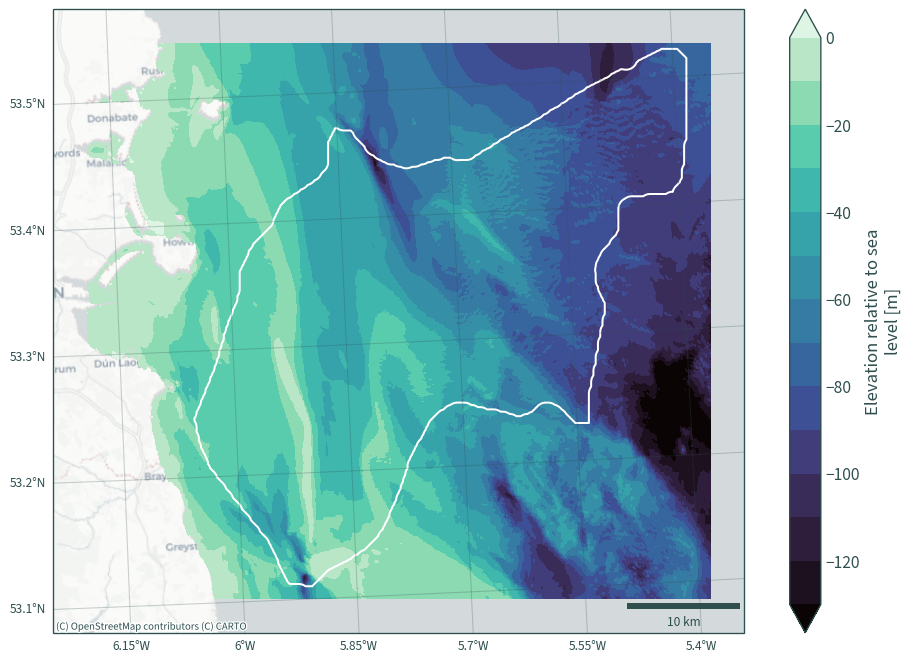

In [19]:
plot_bath_map(data_["elevation"])

## Reproject bathymetry to match the resolution of the Kish Basin data

In [20]:
data_ = data.rename({"lon": "x", "lat": "y"}).rio.reproject_match(
    ds, resampling=rio.enums.Resampling.bilinear
)

In [21]:
data_

<xarray.Dataset> Size: 2MB
Dimensions:             (x: 218, y: 237, cdi_index_count: 21797)
Coordinates:
    crs                 int64 8B 0
  * x                   (x) float64 2kB 6.966e+05 6.968e+05 ... 7.4e+05
  * y                   (y) float64 2kB 5.936e+06 5.936e+06 ... 5.889e+06
Dimensions without coordinates: cdi_index_count
Data variables:
    elevation           (y, x) float32 207kB -15.55 -16.94 ... -60.4 -60.26
    value_count         (y, x) float64 413kB 945.9 1.758e+03 ... 1.0 1.0
    cdi_index           (y, x) float64 413kB 1.856e+04 1.856e+04 ... 1.473e+04
    interpolation_flag  (y, x) float32 207kB 0.0 0.0 0.0 0.0 ... nan nan nan nan
    elevation_max       (y, x) float32 207kB -16.18 -17.76 ... -60.4 -60.26
    elevation_min       (y, x) float32 207kB -15.08 -16.36 ... -60.4 -60.26
    stdev               (y, x) float32 207kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    cdi_reference       (cdi_index_count) object 174kB dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes:
    dtm_convention_version:  1.0
    Conventions:             SeaDataNet_1.0 CF1.6
    title:                   The EMODnet Grid
    institution:             On behalf of the EMODnet project, http://www.emo...
    source:                  source of the data can be found in the dataset o...
    references:              WORK IN PROGRESS 2020 lastest release is DOI: 10...
    comment:                 The data in the EMODnet Grid should not be used ...
    history:                 NetCDF file created with GGSgc NC_Makegrid versi...

In [22]:
data_.rio.crs

CRS.from_epsg(23029)

In [23]:
data_.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

In [24]:
data_.rio.resolution()

(200.0, -200.0)

In [38]:
val = data_["elevation"].values.flatten()
min(val[~np.isnan(val)])

-166.57455

In [39]:
max(val[~np.isnan(val)])

-0.90690255

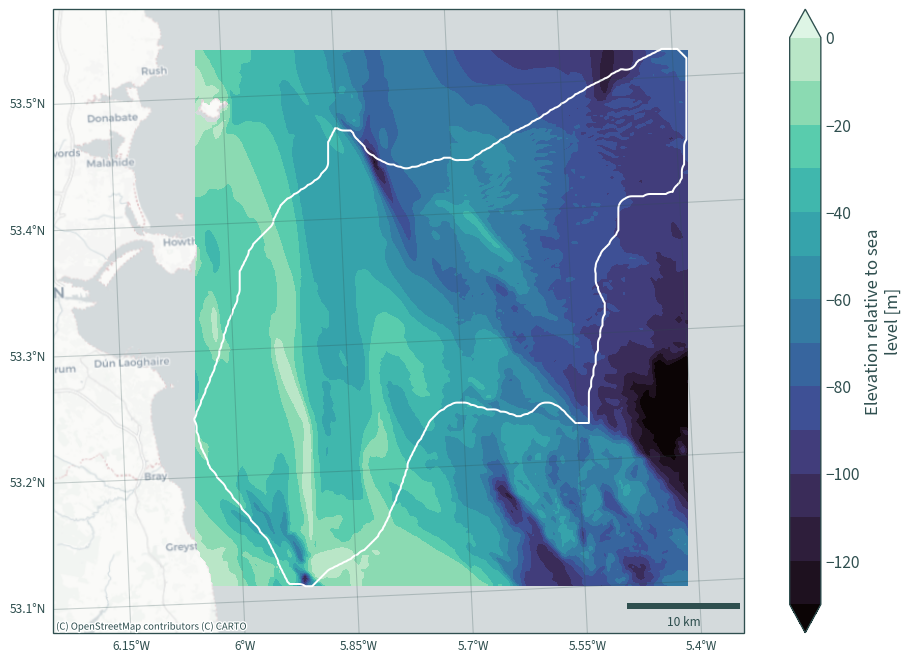

In [27]:
plot_bath_map(data_["elevation"], levels=14, vmax=0, vmin=-130)

## Adjust Kish Basin depth from sea level to seabed

In [28]:
ds = ds.assign(TopDepthSeabed=ds["TopDepth"] + data_["elevation"])
ds = ds.assign(BaseDepthSeabed=ds["BaseDepth"] + data_["elevation"])

In [29]:
# ds["TopDepthSeabed"].attrs = ds["TopDepth"].attrs
# ds["BaseDepthSeabed"].attrs = ds["BaseDepth"].attrs

In [30]:
ds

<xarray.Dataset> Size: 10MB
Dimensions:          (halite: 4, y: 237, x: 218)
Coordinates:
  * y                (y) float64 2kB 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x                (x) float64 2kB 6.966e+05 6.968e+05 ... 7.398e+05 7.4e+05
    spatial_ref      int64 8B 0
  * halite           (halite) <U8 128B 'Fylde' 'Mythop' 'Preesall' 'Rossall'
    crs              int64 8B 0
Data variables:
    BaseDepth        (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    Thickness        (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    TopDepth         (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    TopTWT           (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    TopDepthSeabed   (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan
    BaseDepthSeabed  (halite, y, x) float64 2MB nan nan nan nan ... nan nan nan

In [40]:
val = ds["TopDepthSeabed"].values.flatten()
min(val[~np.isnan(val)])

69.23700712890626

In [41]:
max(val[~np.isnan(val)])

3234.9487763793945

In [42]:
val = ds["BaseDepthSeabed"].values.flatten()
min(val[~np.isnan(val)])

73.09180877075195

In [43]:
max(val[~np.isnan(val)])

3475.1658741638184

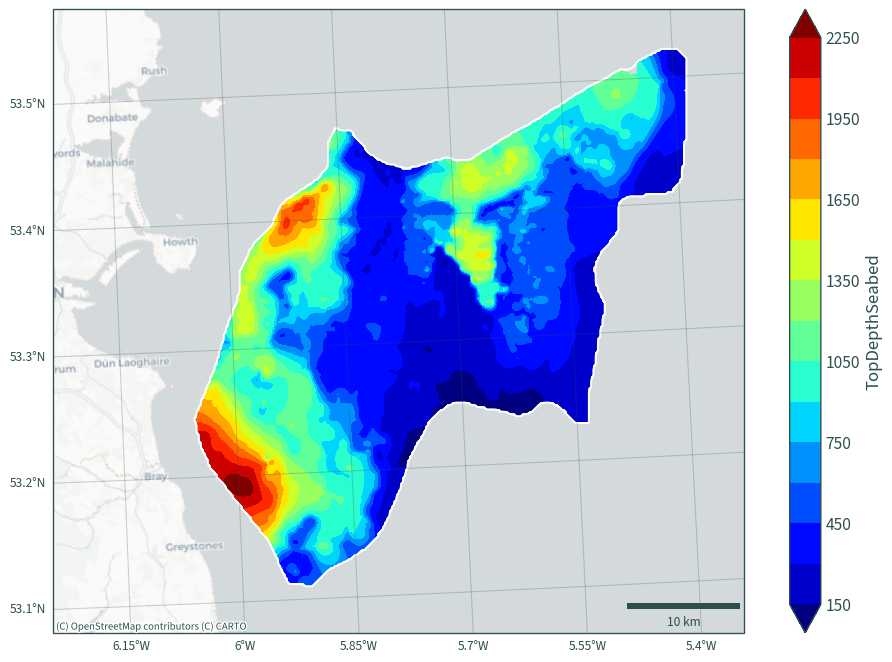

In [35]:
plot_bath_map(
    ds["TopDepthSeabed"].sel(halite="Rossall"), cmap="jet", vmin=150, vmax=2250
)

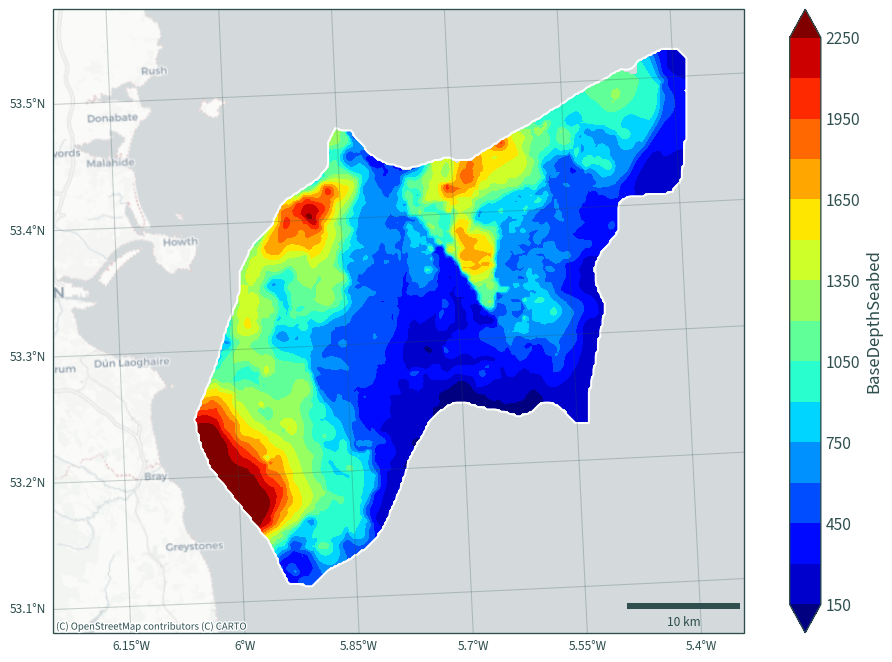

In [36]:
plot_bath_map(ds["BaseDepthSeabed"].sel(halite="Rossall"), cmap="jet")